In [19]:
# GPU -- 准备来做一个GPU版本的RNN
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())

# 方法2，将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组

# # 数据转成sequence的格式，这里定义每个seq的长度
seq_len = 45
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(seq_len):
    if i.shape[0] == seq_len:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, seq_len, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(seq_len))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, seq_len, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - 1
test_batch_count = total_batch_count - train_batch_count

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(180, 123)
rolling_data shape: (136, 45, 123)
seq count: 136
seq length: 45
total batch count: 136
batch size: 1
rolling_data: torch.Size([136, 1, 45, 123])
train_x: torch.Size([135, 1, 45, 122])
train_y: torch.Size([135, 1, 45, 1])
test_x:  torch.Size([1, 1, 45, 122])
test_y:  torch.Size([1, 1, 45, 1])
train_batch_count: 135
test_batch_count:  1


In [1]:
# 初始化 LSTM 模型
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.to(device)
LR = 1e-4
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)

print(model)

# 训练 LSTM 模型; 
i = 0

epoches = 100
print(time.ctime())
for epoch in range(epoches):
    for step in range(train_batch_count):
        # print(train_x[i])
        # print(train_x[i].shape)
        model = model.double()

        pred = model(train_x[i])

        loss = loss_func(pred, train_y[i])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()

        if (i+1)%train_batch_count == 0:
            i=0
        else:
            i=i+1
    if (epoch+1)%10 == 0:
        print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, loss.item()))

print(time.ctime())

NameError: name 'LSTMModel' is not defined

loss: 0.000006
今天预测涨跌: tensor([1.7113], dtype=torch.float64)
明天预测涨跌: tensor([1.4713], dtype=torch.float64)


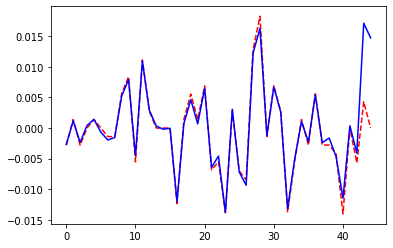

In [18]:
pred = model(test_x[0])

test_y=test_y.cpu()
pred = pred.cpu()

loss = loss_func(pred, test_y[0])
print("loss: {:.6f}".format(loss.item()))
print("预测明天涨跌: {}".format(pred[-1][-1].data*100))

# actual_line = np.array(test_y[0]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

actual_line = np.array(test_y[0][-1]).flatten().tolist()
pred_line = pred[-1].data.numpy().flatten().tolist()

plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()